# Example: 2D ring resonator

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), or just follow along with the output below.

This is a simple example of using Tidy3D to simulate a common photonics application.

We perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 1 million grid points to model the entire domain and 115,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform each simulation in just under 1 minute!

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.01

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

# set number of PMLs on each side
npml = 15

In [3]:
# define pulse parameters
pol = 'TE'  # 'TE' or 'TM'.  TE means waveguide excited Ey, TM means waveguide excited Ez
lambda_central = 0.5
f_center = td.C_0 /lambda_central
f_width =  f_center / 6
grids_per_wavelength = lambda_central / dl
run_time = 500 / f_width

Define materials. [(docs)](https://simulation.cloud/docs/html/api.html#material)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(epsilon=n_bg**2)
solid = td.Medium(epsilon=n_solid**2)

Define structures. [(docs)](https://simulation.cloud/docs/html/api.html#structure)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Box(
    center=[0, 0, 0],
    size=[td.inf, td.inf, td.inf],
    material=background,
    name='background')

# waveguide
waveguide = td.Box(
    center=[0, wg_center_y, 0],
    size=[td.inf, wg_width, td.inf],
    material=solid,
    name='waveguide')

# outside ring
outer_ring = td.Cylinder(
    center=[0,0,0],
    axis='z',
    radius=ring_radius+ring_wg_width/2.0,
    height=td.inf,
    material=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Cylinder(
    center=[0,0,0],
    axis='z',
    radius=ring_radius-ring_wg_width/2.0,
    height=td.inf,
    material=background,
    name='inner_ring')

Define modal source. [(docs)](https://simulation.cloud/docs/html/api.html#source)

In [6]:
source = td.ModeSource(
    td.GaussianPulse(f_center, f_width, phase=0),
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
    direction='forward',
    amplitude=1.0,
    name='modal_source')

Define monitors. [(docs)](https://simulation.cloud/docs/html/api.html#monitor)

In [7]:
# monitor of the output mode amplitude at a range of frequencies
mode_monitor = td.ModeMonitor(
    center=[wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
    freqs=f_center,
    name='mode_amps')

# monitor steady state fields at central frequency over whole domain
field_monitor = td.FreqMonitor(
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    freqs=f_center,
    field=['E', 'H'],
    name='full_domain_fields')

# monitor the time series at a point in the center of the output waveguide
time_monitor = td.TimeMonitor(
    center=[wg_insert_x, wg_center_y, 0],
    size=[0, 0, 0],
    name='time_series')

Define simulation. [(docs)](https://simulation.cloud/docs/html/api.html#simulation)

In [8]:
# create normalization simulation (no ring)
sim0 = td.Simulation(size=[x_span, y_span, 1*dl],
                    mesh_step=[dl, dl, dl],
                    structures=[background_box, waveguide],
                    sources=[source],
                    monitors=[mode_monitor, field_monitor, time_monitor],
                    run_time = run_time,
                    pml_layers=[npml, npml, 0])

# create simulation (with ring)
sim = td.Simulation(size=[x_span, y_span, 1*dl],
                    mesh_step=[dl, dl, dl],
                    structures=[background_box, waveguide, outer_ring, inner_ring],
                    sources=[source],
                    monitors=[mode_monitor, field_monitor, time_monitor],
                    run_time = run_time,
                    pml_layers=[npml, npml, 0])

Initializing simulation...
Mesh step (micron): [1.00e-02, 1.00e-02, 1.00e-02].
Simulation domain in number of grid points: [1530, 1210, 1].
Total number of grid points: 1.85e+06.
Total number of time steps: 288676.
Estimated data size (GB) of monitor mode_amps: 0.0000.
Estimated data size (GB) of monitor full_domain_fields: 0.0793.
Estimated data size (GB) of monitor monitor_0: 0.0069.
Initializing simulation...
Mesh step (micron): [1.00e-02, 1.00e-02, 1.00e-02].
Simulation domain in number of grid points: [1530, 1210, 1].
Total number of grid points: 1.85e+06.
Total number of time steps: 288676.
Estimated data size (GB) of monitor mode_amps: 0.0000.
Estimated data size (GB) of monitor full_domain_fields: 0.0793.
Estimated data size (GB) of monitor monitor_0: 0.0069.


----
Visualize structure, source, and modes. [(docs)](https://simulation.cloud/docs/html/api.html#plotting-tools)

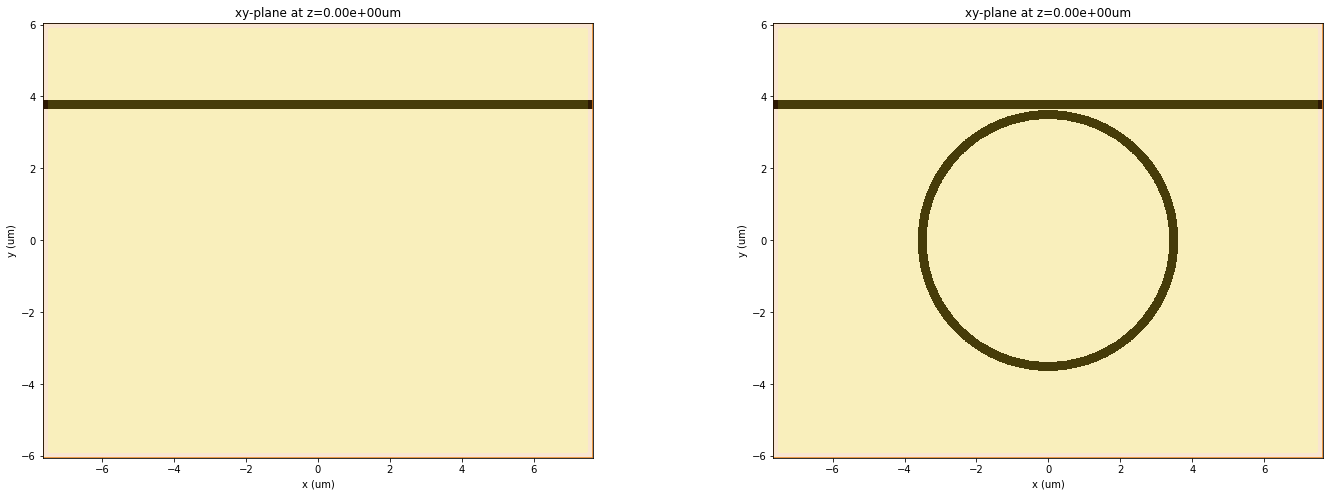

In [9]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
sim0.viz_eps_2D(normal='z', position=0.0, ax=ax1)
sim.viz_eps_2D(normal='z', position=0.0, ax=ax2)
plt.show()

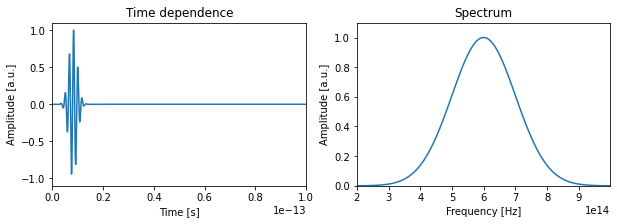

In [10]:
# visualize time series of source
ax1, ax2 = sim.viz_source(source)
ax1.set_xlim((0, 0.1e-12))  # note the pulse extends far beyond this time, adjust lims to inspect
plt.show()

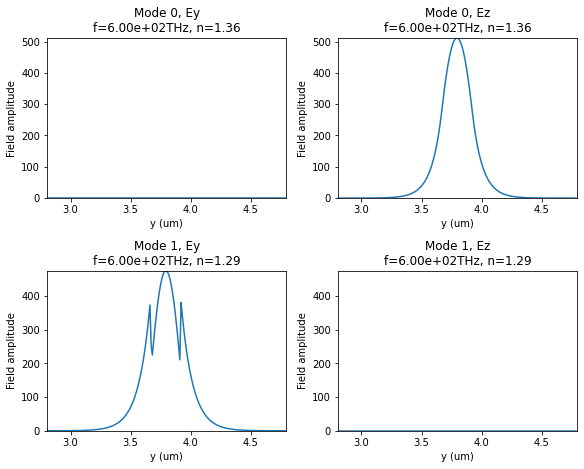

In [11]:
# Visualize the first two modes of the mode source
sim.viz_modes(source, mode_inds=[0, 1]);

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

In [12]:
if pol == 'TM':
    mode_index = 0
elif pol == 'TE':
    mode_index = 1
else:
    raise ValueError('pol must be TM or TE')

# set the mode index of modal source in each sim
sim0.set_mode(source, mode_ind=mode_index)
sim.set_mode(source, mode_ind=mode_index)

# you can ignore the warning that occurs because the mode extends in the out of plane direction

Selected mode index larger than number of stored modes. Recomputing eigenmodes modes up to mode index.


----
## Run Simulation
Run simulations on our server. [(docs)](https://simulation.cloud/docs/html/api.html#web-api)

In [13]:
def run_tidy3d(sim, task_name=''):
    # Convenience function to run a simulation and download results
    
    # create a project, upload to our server to run
    project = web.new_project(sim.export(), task_name=task_name)
    task_id = project['taskId']
    web.monitor_project(task_id)

    # download the results and load into the original simulation
    print('downloading results...')
    web.download_results(task_id, target_folder='out')
    print('done\n')
    sim.load_results('out/monitor_data.hdf5')
    
    # print some stats from the log
    !cat out/tidy3d.log
    print('\n')

In [14]:
# use function above to run simulation with and without ring
run_tidy3d(sim0, task_name='normalization')
run_tidy3d(sim, task_name='with_ring')

Uploading the json file...
Project "normalization-22" status: success...        

downloading results...
done

Applying source normalization to all frequency monitors using source index 0.
Simulation domain Nx, Ny, Nz: 1530, 1210, 1.
Total number of computational grid points: 1.85e+06.
Total number of time steps: 288676.
Starting Tidy3D... 

Setup time (s): 0.4888
- Time step  14433  (  5 % done), field decay: 1.00e+00
- Time step  28867  ( 10 % done), field decay: 1.00e+00
- Time step  43301  ( 15 % done), field decay: 1.00e+00
- Time step  57735  ( 20 % done), field decay: 9.13e-01
- Time step  72168  ( 25 % done), field decay: 9.24e-01
- Time step  86602  ( 30 % done), field decay: 9.71e-01
- Time step 101036  ( 35 % done), field decay: 9.27e-01
- Time step 115470  ( 40 % done), field decay: 9.80e-01
- Time step 129904  ( 45 % done), field decay: 9.44e-01
- Time step 144337  ( 50 % done), field decay: 9.35e-01
- Time step 158771  ( 55 % done), field decay: 9.40e-01
- Time step 17320

In [15]:
# which components of the electric field to plot, depending on polarization
if pol == 'TM':
    comps = ('z',)
elif pol == 'TE':
    comps = ('x', 'y')
else:
    raise ValueError('pol must be TM or TE')

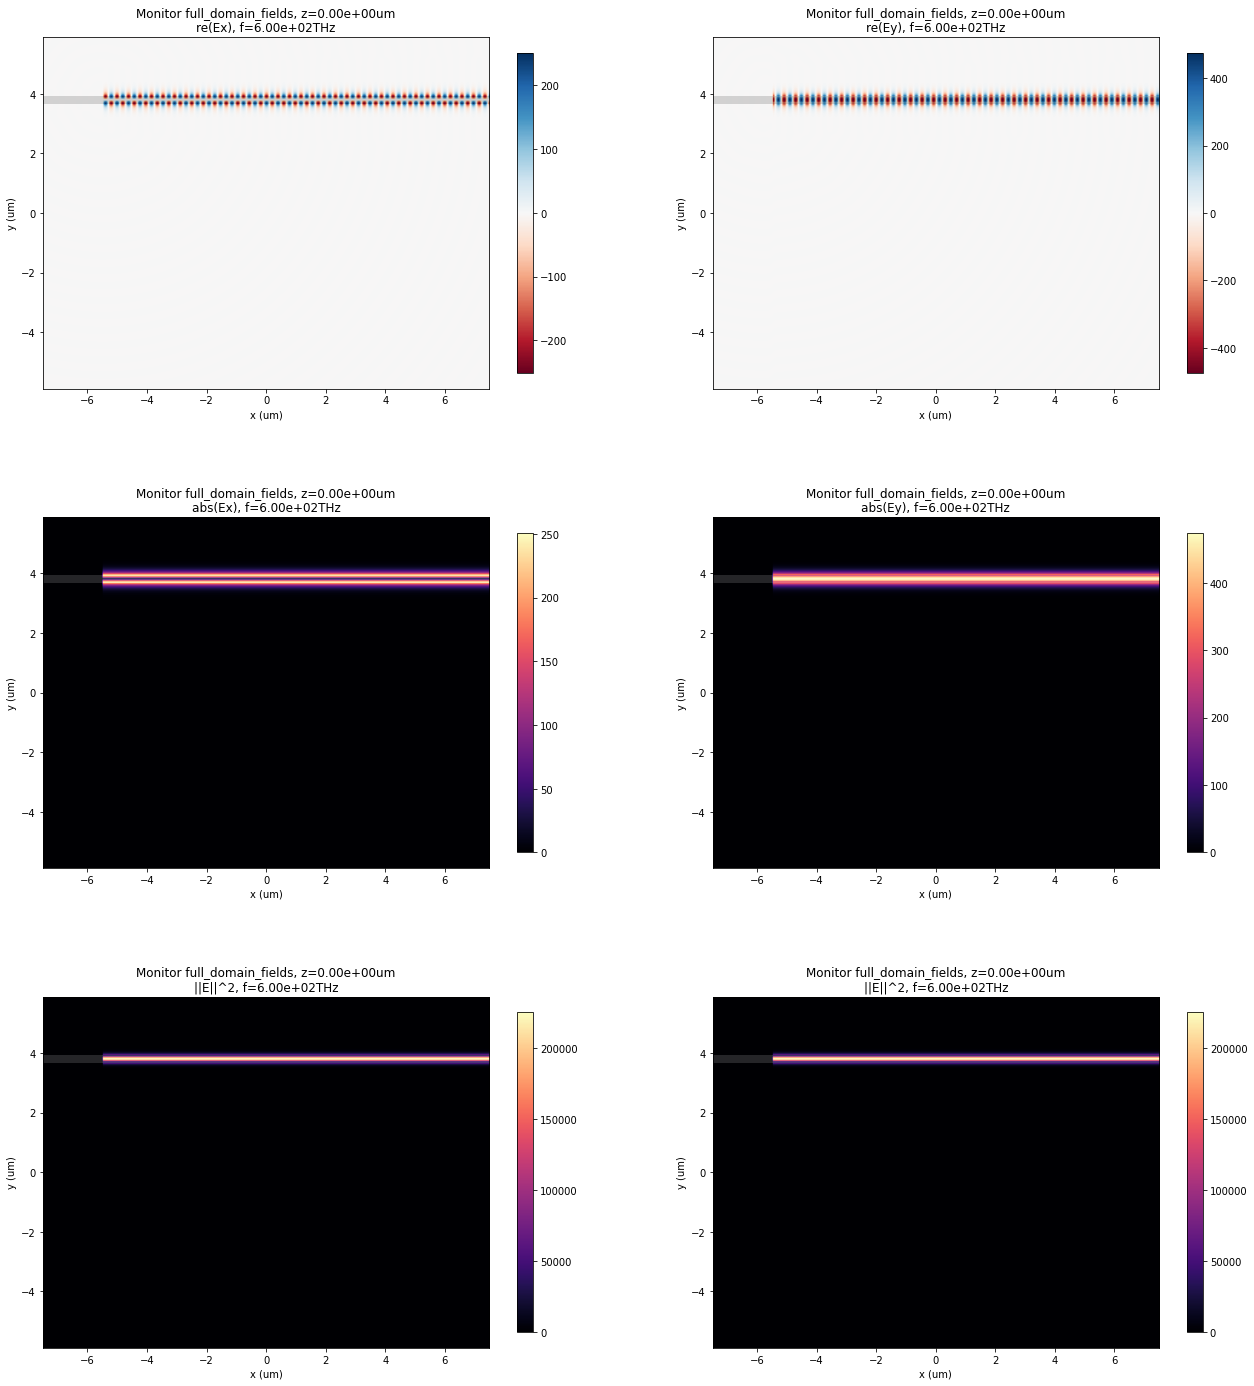

In [16]:
# visualize normalization run
fig, axes = plt.subplots(3, len(comps), figsize=(22, 25))
for axe, val in zip(axes.reshape(3, len(comps)), ('re', 'abs', 'int')):
    for ax, comp in zip(axe, comps):
        im = sim0.viz_field_2D(field_monitor, sample_ind=0, eps_alpha=0.15, comp=comp, val=val, cbar=True, ax=ax)

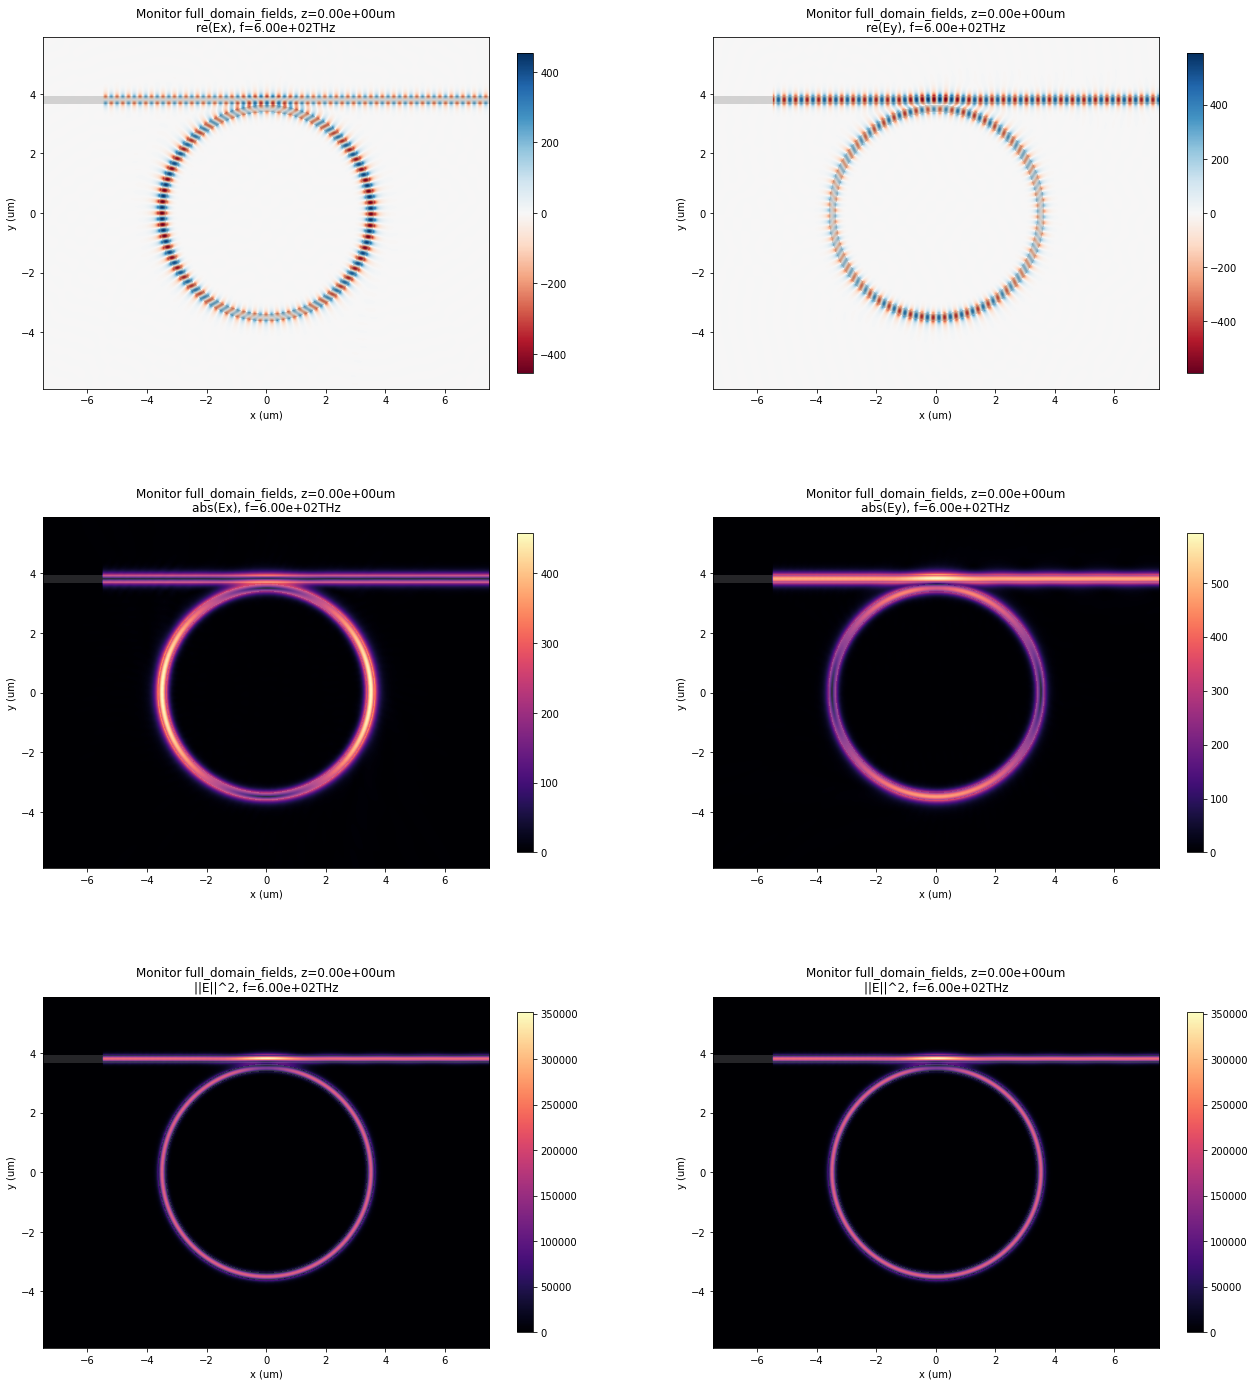

In [17]:
# visualize run with ring
fig, axes = plt.subplots(3, len(comps), figsize=(22, 25))
for axe, val in zip(axes.reshape(3, len(comps)), ('re', 'abs', 'int')):
    for ax, comp in zip(axe, comps):
        im = sim.viz_field_2D(field_monitor, sample_ind=0, eps_alpha=0.15, comp=comp, val=val, cbar=True, ax=ax)

## Analyze Spectrum
Analyze transmission spectrum using fourier transform. [(docs)](https://simulation.cloud/docs/html/api.html#miscellaneous)

In [18]:
# Get data from the TimeMonitor
tdata0 = sim0.data(time_monitor)
tdata = sim.data(time_monitor)
tmesh = tdata["tmesh"]
Nt = tmesh.size
dt = tmesh[1] - tmesh[0]

# select output fields as Ez if TM or Ey if TE
field_index = 2 if pol == 'TM' else 1

E_out0 = tdata0['E'][field_index, 0, 0, 0, :]
E_out = tdata['E'][field_index, 0, 0, 0, :]

# frequencies to measure output spectrum at
freqs = td.C_0 / np.linspace(0.4, 0.6, 1000)

# fourier transform output time series to get spectrum at freqs
E_out0_f = td.dft_spectrum(E_out0, dt, freqs)
E_out_f = td.dft_spectrum(E_out, dt, freqs)

Plot results.

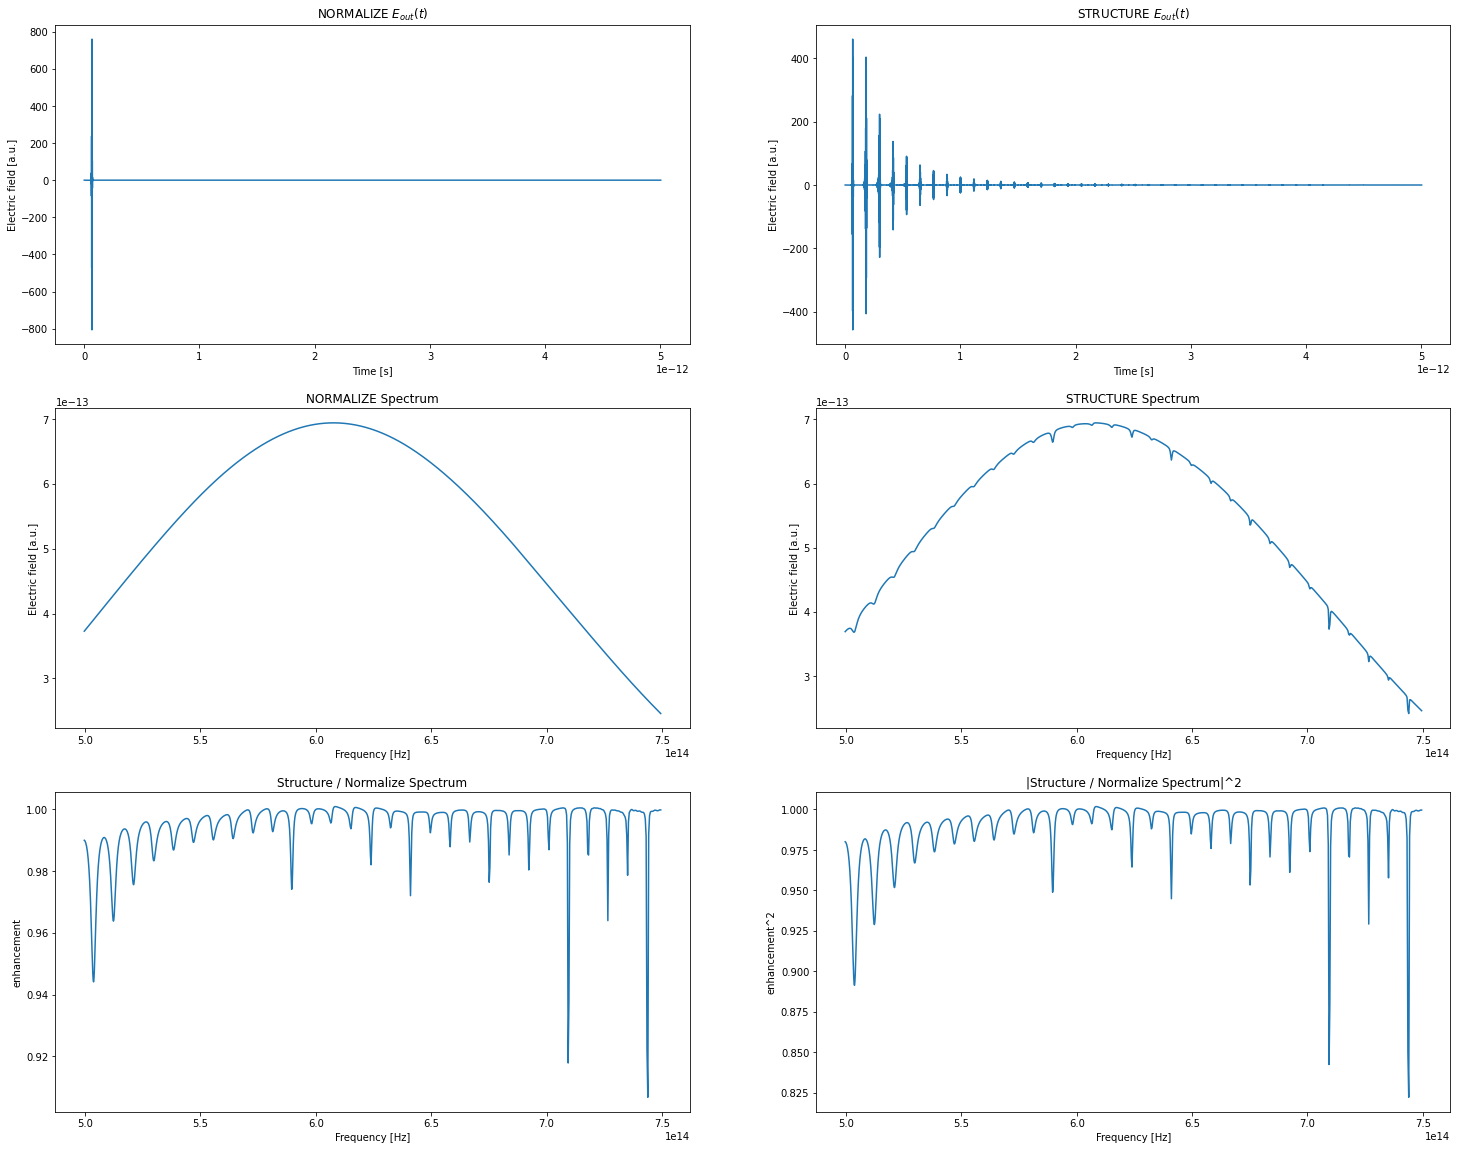

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

# plot time series normalization
ax[0, 0].plot(tmesh, E_out0)
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("Electric field [a.u.]");
ax[0, 0].set_title("NORMALIZE $E_{out}(t)$")

# plot time series with ring
ax[0, 1].plot(tmesh, E_out)
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Electric field [a.u.]");
ax[0, 1].set_title("STRUCTURE $E_{out}(t)$")

# plot spectrum of normalization (input)
ax[1, 0].plot(freqs, np.abs(E_out0_f))
ax[1, 0].set_xlabel("Frequency [Hz]")
ax[1, 0].set_ylabel("Electric field [a.u.]");
ax[1, 0].set_title("NORMALIZE Spectrum");

# plot transmission spectrum with ring
ax[1, 1].plot(freqs, np.abs(E_out_f))
ax[1, 1].set_xlabel("Frequency [Hz]")
ax[1, 1].set_ylabel("Electric field [a.u.]");
ax[1, 1].set_title("STRUCTURE Spectrum");

# plot spectrum ratio |E_ring(f)| / |E_norm(f)|
ax[2, 0].plot(freqs, np.abs(E_out_f) / np.abs(E_out0_f))
ax[2, 0].set_xlabel("Frequency [Hz]")
ax[2, 0].set_ylabel("enhancement");
ax[2, 0].set_title("Structure / Normalize Spectrum");

# plot square of spectrum ratio ( |E_ring(f)| / |E_norm(f)| )^2
ax[2, 1].plot(freqs, (np.abs(E_out_f) / np.abs(E_out0_f))**2)
ax[2, 1].set_xlabel("Frequency [Hz]")
ax[2, 1].set_ylabel("enhancement^2");
ax[2, 1].set_title("|Structure / Normalize Spectrum|^2");

In [20]:
# add your analysis here!
